# SHO Fitter Inferency Noisy Results Visualization

In [1]:
import sys
sys.path.append('../../')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import seaborn as sns
import time
import pandas as pd
import os
import gc

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from scipy.signal import resample
from sklearn.preprocessing import StandardScaler

from src.m3_learning.be.processing import convert_amp_phase, transform_params, SHO_fit_to_array
from src.m3_learning.util.preprocessing import global_scaler

## Loads data

In [4]:
# Sets path to file
path = r"./"

# Opens the data file
h5_f = h5py.File(path + "data_file.h5", "r+")

# number of pixels in the image
num_pix = h5_f["Measurement_000"].attrs["num_pix"]

num_pix_1d = int(np.sqrt(num_pix))

# Frequency Vector in Hz
frequency_bin = h5_f["Measurement_000"]["Channel_000"]["Bin_Frequencies"][:]

# extracting spectroscopic values
spectroscopic_values = h5_f['Measurement_000']['Channel_000']['Spectroscopic_Values']

# number of DC voltage steps
voltage_steps = h5_f["Measurement_000"].attrs["num_udvs_steps"]

# Resampled frequency vector
wvec_freq = resample(frequency_bin, 80)

# get raw data (real and imaginary combined)
raw_data = h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]
raw_data_resampled = resample(np.array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]).reshape(-1, 165), 80, axis=1)

# conversion of raw data (both resampled and full)
amp, phase = convert_amp_phase(raw_data)
amp_resample, phase_resample = convert_amp_phase(raw_data_resampled)

scaled_data = h5_f["Measurement_000"]["Channel_000"]['complex']['scaled_data'][:]
real_resample = h5_f["Measurement_000"]["Channel_000"]['complex']['real_resample'][:]
imag_resample = h5_f["Measurement_000"]["Channel_000"]['complex']['imag_resample'][:]

# scale the real component of input data
scaler_real = global_scaler()
scaled_data_real = scaler_real.fit_transform(real_resample).reshape(-1, 80)

# scale the imaginary component of input data
scaler_imag = global_scaler()
scaled_data_imag = scaler_imag.fit_transform(imag_resample).reshape(-1, 80)

In [5]:
# create a list for parameters
fit_results_list = SHO_fit_to_array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"])

# flatten parameters list into numpy array
fit_results_list = np.array(fit_results_list).reshape(num_pix, voltage_steps, 5)

# exclude the R2 parameter
params = fit_results_list.reshape(-1, 5)[:, 0:4]

# scale the parameters (now takes only 4 parameters, excluding the R2)
params_scaler = StandardScaler()
scaled_params = params_scaler.fit_transform(fit_results_list.reshape(-1, 5)[:, 0:4])

In [6]:
# create a list for parameters
pred_results_list = []
for sublist in np.array(
    h5_f["Measurement_000"]["Channel_000"]["Raw_Data-Predictions_000"]["SHO_Pred_Results"]
):
    for item in sublist:
        for i in item:
            pred_results_list.append(i)

# flatten parameters list into numpy array
pred_results_list = np.array(pred_results_list).reshape(num_pix, voltage_steps, 4)

# exclude the R2 parameter
all_pred_params = pred_results_list.reshape(-1, 4)

all_pred_params_scaled = params_scaler.transform(all_pred_params.copy())

In [7]:
lowest_noise_real = -1.0 * 0.0026878386 # 2.6e-3
highest_noise_real = 1.0 * 0.0026878386
lowest_noise_imag = -1.0 * 0.0027575183
highest_noise_imag = 1.0 * 0.0027575183

noise_real = np.random.uniform(lowest_noise_real, highest_noise_real, (3600, 63360))
noise_imag = np.random.uniform(lowest_noise_imag, highest_noise_imag, (3600, 63360))
noise = noise_real+noise_imag*1.0j

noise_levels = ['2.0', '4.0', '7.0']

In [8]:
noise_real_nn = (np.real(noise) - (-6.855169e-06)) / 0.0026878386
noise_imag_nn = (np.imag(noise) - (0.00013161483)) / 0.0027575183

noise_real_nn = noise_real_nn.reshape(-1, 165)
noise_imag_nn = noise_imag_nn.reshape(-1, 165)

noise_nn = np.stack((noise_real_nn, noise_imag_nn), axis=2)
del noise_real_nn
del noise_imag_nn
noise_nn_resampled = resample(noise_nn, 80, axis=1)
del noise_nn

## PyTorch Model

In [9]:
class SHO_Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Input block of 1d convolution
        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
        )

        # fully connected block
        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 20),
            nn.SELU(),
            nn.Linear(20, 20),
            nn.SELU(),
        )

        # 2nd block of 1d-conv layers
        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
        )

        # Flatten layer
        self.flatten_layer = nn.Flatten()
        
        # Final embedding block - Output 4 values - linear
        self.hidden_embedding = nn.Sequential(
            nn.Linear(26, 16),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, 4),
        )

    def forward(self, x, n=-1):
      x = torch.swapaxes(x, 1, 2) # output shape - samples, (real, imag), frequency
      x = self.hidden_x1(x)
      xfc = torch.reshape(x, (n, 256)) # batch size, features
      xfc = self.hidden_xfc(xfc)
      x = torch.reshape(x, (n, 2, 128)) # batch size, (real, imag), timesteps
      x = self.hidden_x2(x)
      cnn_flat = self.flatten_layer(x)
      encoded = torch.cat((cnn_flat, xfc), 1) # merge dense and 1d conv.
      embedding = self.hidden_embedding(encoded) # output is 4 parameters

      # corrects the scaling of the parameters
      unscaled_param = embedding*torch.tensor(params_scaler.var_[0:4]**0.5).cuda() + torch.tensor(params_scaler.mean_[0:4]).cuda()
      return unscaled_param

## Performs inference and plots results

In [10]:
# initial fit
fit_results_list_init = fit_results_list[:, :, 4]

# dummy initialization
initial_maps = np.zeros(1000)
lsqf_maps_2 = np.zeros(1000)
lsqf_maps_4 = np.zeros(1000)
lsqf_maps_7 = np.zeros(1000)
nn_maps_2 = np.zeros(1000)
nn_maps_4 = np.zeros(1000)
nn_maps_7 = np.zeros(1000)
all_params_transformed = np.zeros(1000)

initial_params = np.zeros(1000)
lsqf_params_2 = np.zeros(1000)
nn_params_2 = np.zeros(1000)
lsqf_params_4 = np.zeros(1000)
nn_params_4 = np.zeros(1000)
lsqf_params_7 = np.zeros(1000)
nn_params_7 = np.zeros(1000)

In [17]:
h5_f_fit_noise.filename

'./data_file_noise_7.0.h5'

In [20]:

h5_f.filename

'./data_file.h5'

In [26]:
fit_results_list_noise == fit_results_list_noise_2

array([[[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        ...,
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       [[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        ...,
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       [[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        ...,
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       ...,

       [[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        ...,
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       [[ True,

(array([4.6065e+04, 2.0900e+02, 1.0430e+03, 2.8350e+03, 5.2550e+03,
        7.5980e+03, 9.4440e+03, 1.0545e+04, 1.1170e+04, 1.1533e+04,
        1.1942e+04, 1.2063e+04, 1.2513e+04, 1.2902e+04, 1.3071e+04,
        1.3269e+04, 1.3922e+04, 1.4007e+04, 1.4688e+04, 1.4835e+04,
        1.4937e+04, 1.5850e+04, 1.6094e+04, 1.6362e+04, 1.6609e+04,
        1.7088e+04, 1.6910e+04, 1.7000e+04, 1.7142e+04, 1.7261e+04,
        1.7711e+04, 1.7856e+04, 1.8286e+04, 1.8856e+04, 1.9326e+04,
        1.9593e+04, 2.0363e+04, 2.0677e+04, 2.1214e+04, 2.1872e+04,
        2.2294e+04, 2.2474e+04, 2.2911e+04, 2.3435e+04, 2.3727e+04,
        2.3945e+04, 2.4266e+04, 2.4828e+04, 2.4975e+04, 2.5119e+04,
        2.5500e+04, 2.5416e+04, 2.5522e+04, 2.5540e+04, 2.5699e+04,
        2.5391e+04, 2.5043e+04, 2.4655e+04, 2.4375e+04, 2.3673e+04,
        2.3017e+04, 2.2088e+04, 2.1512e+04, 2.0429e+04, 1.9364e+04,
        1.8219e+04, 1.6701e+04, 1.5739e+04, 1.4925e+04, 1.3839e+04,
        1.3052e+04, 1.2078e+04, 1.1022e+04, 1.02

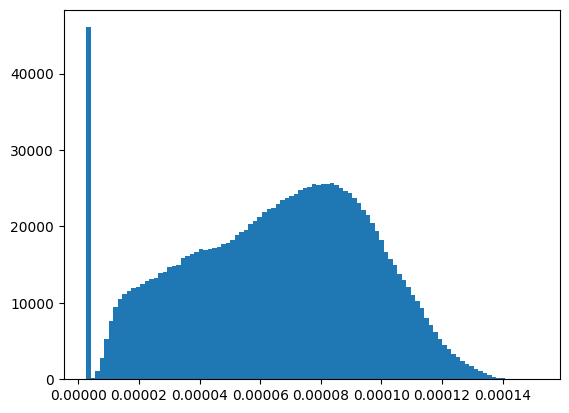

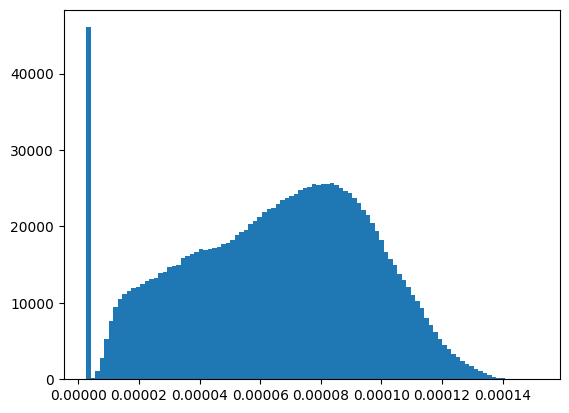

In [24]:
fit_results_list_noise = SHO_fit_to_array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"])

# flatten parameters list into numpy array
fit_results_list_noise = np.array(fit_results_list_noise).reshape(num_pix,voltage_steps,5).copy()
fit_results_list_noise = fit_results_list_noise[:, :, :4]


plt.hist(fit_results_list_noise[:, :, 0].flatten(), bins=100)

plt.figure()

fit_results_list_noise_2 = SHO_fit_to_array(h5_f_fit_noise["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"])

# flatten parameters list into numpy array
fit_results_list_noise_2 = np.array(fit_results_list_noise_2).reshape(num_pix,voltage_steps,5).copy()
fit_results_list_noise_2 = fit_results_list_noise_2[:, :, :4]

plt.hist(fit_results_list_noise_2[:, :, 0].flatten(), bins=100)

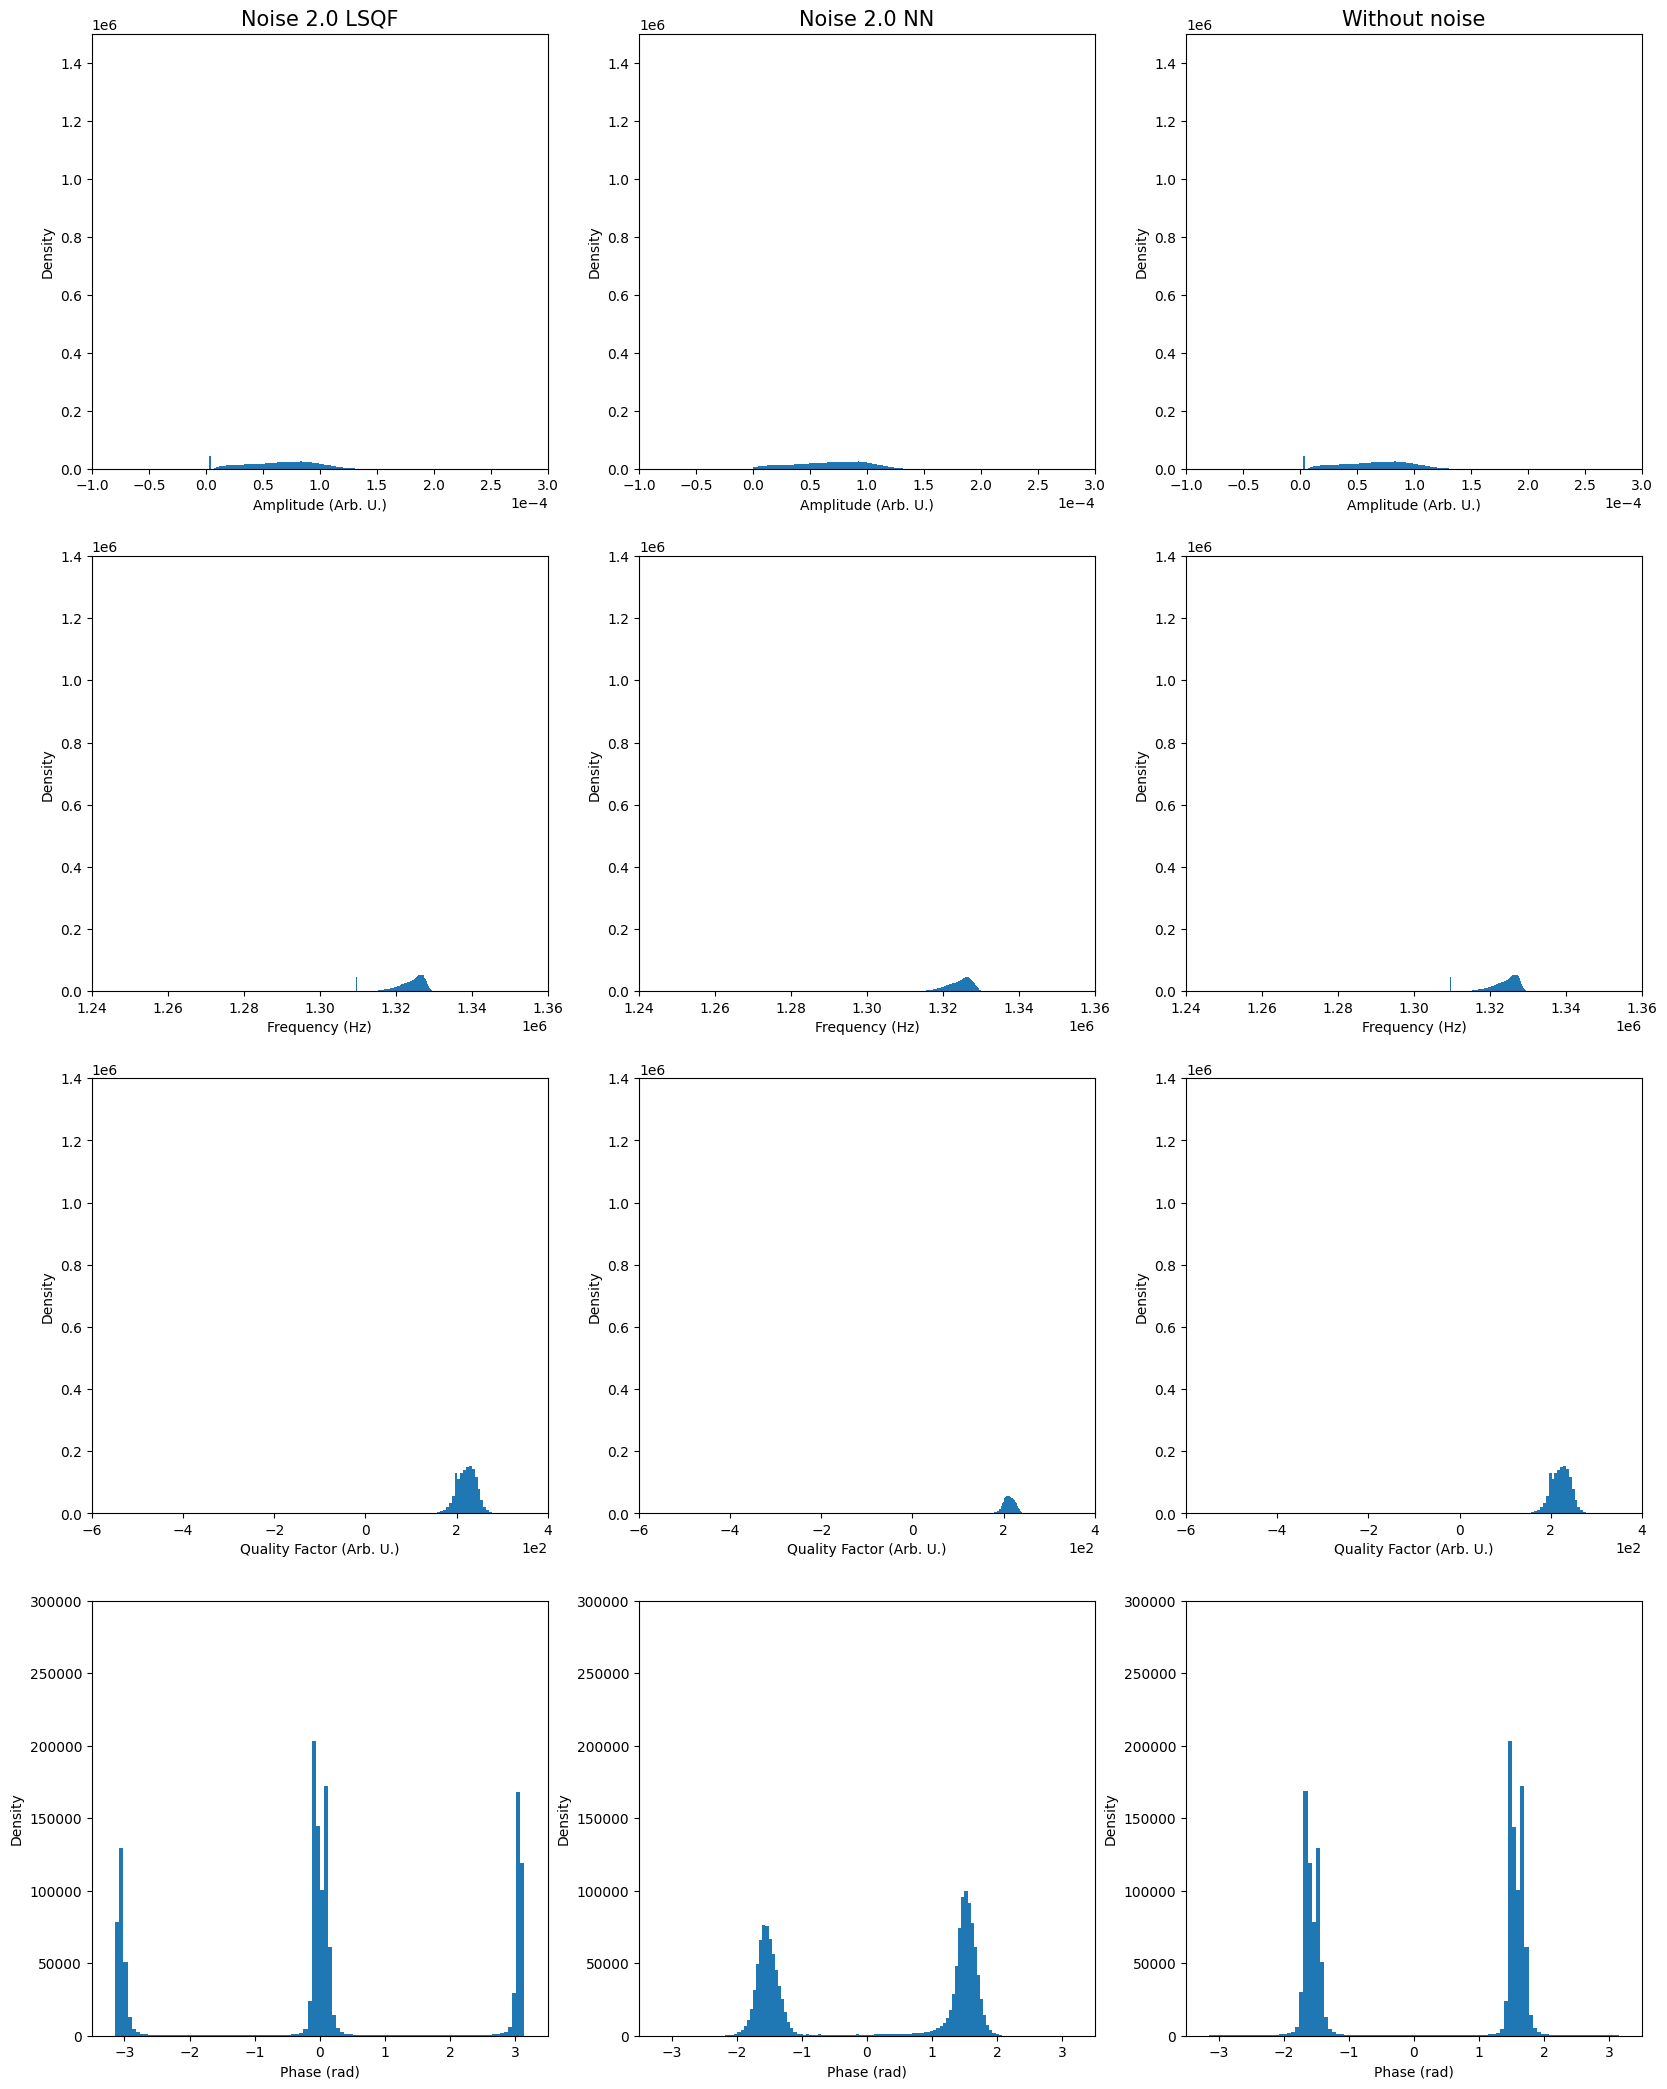

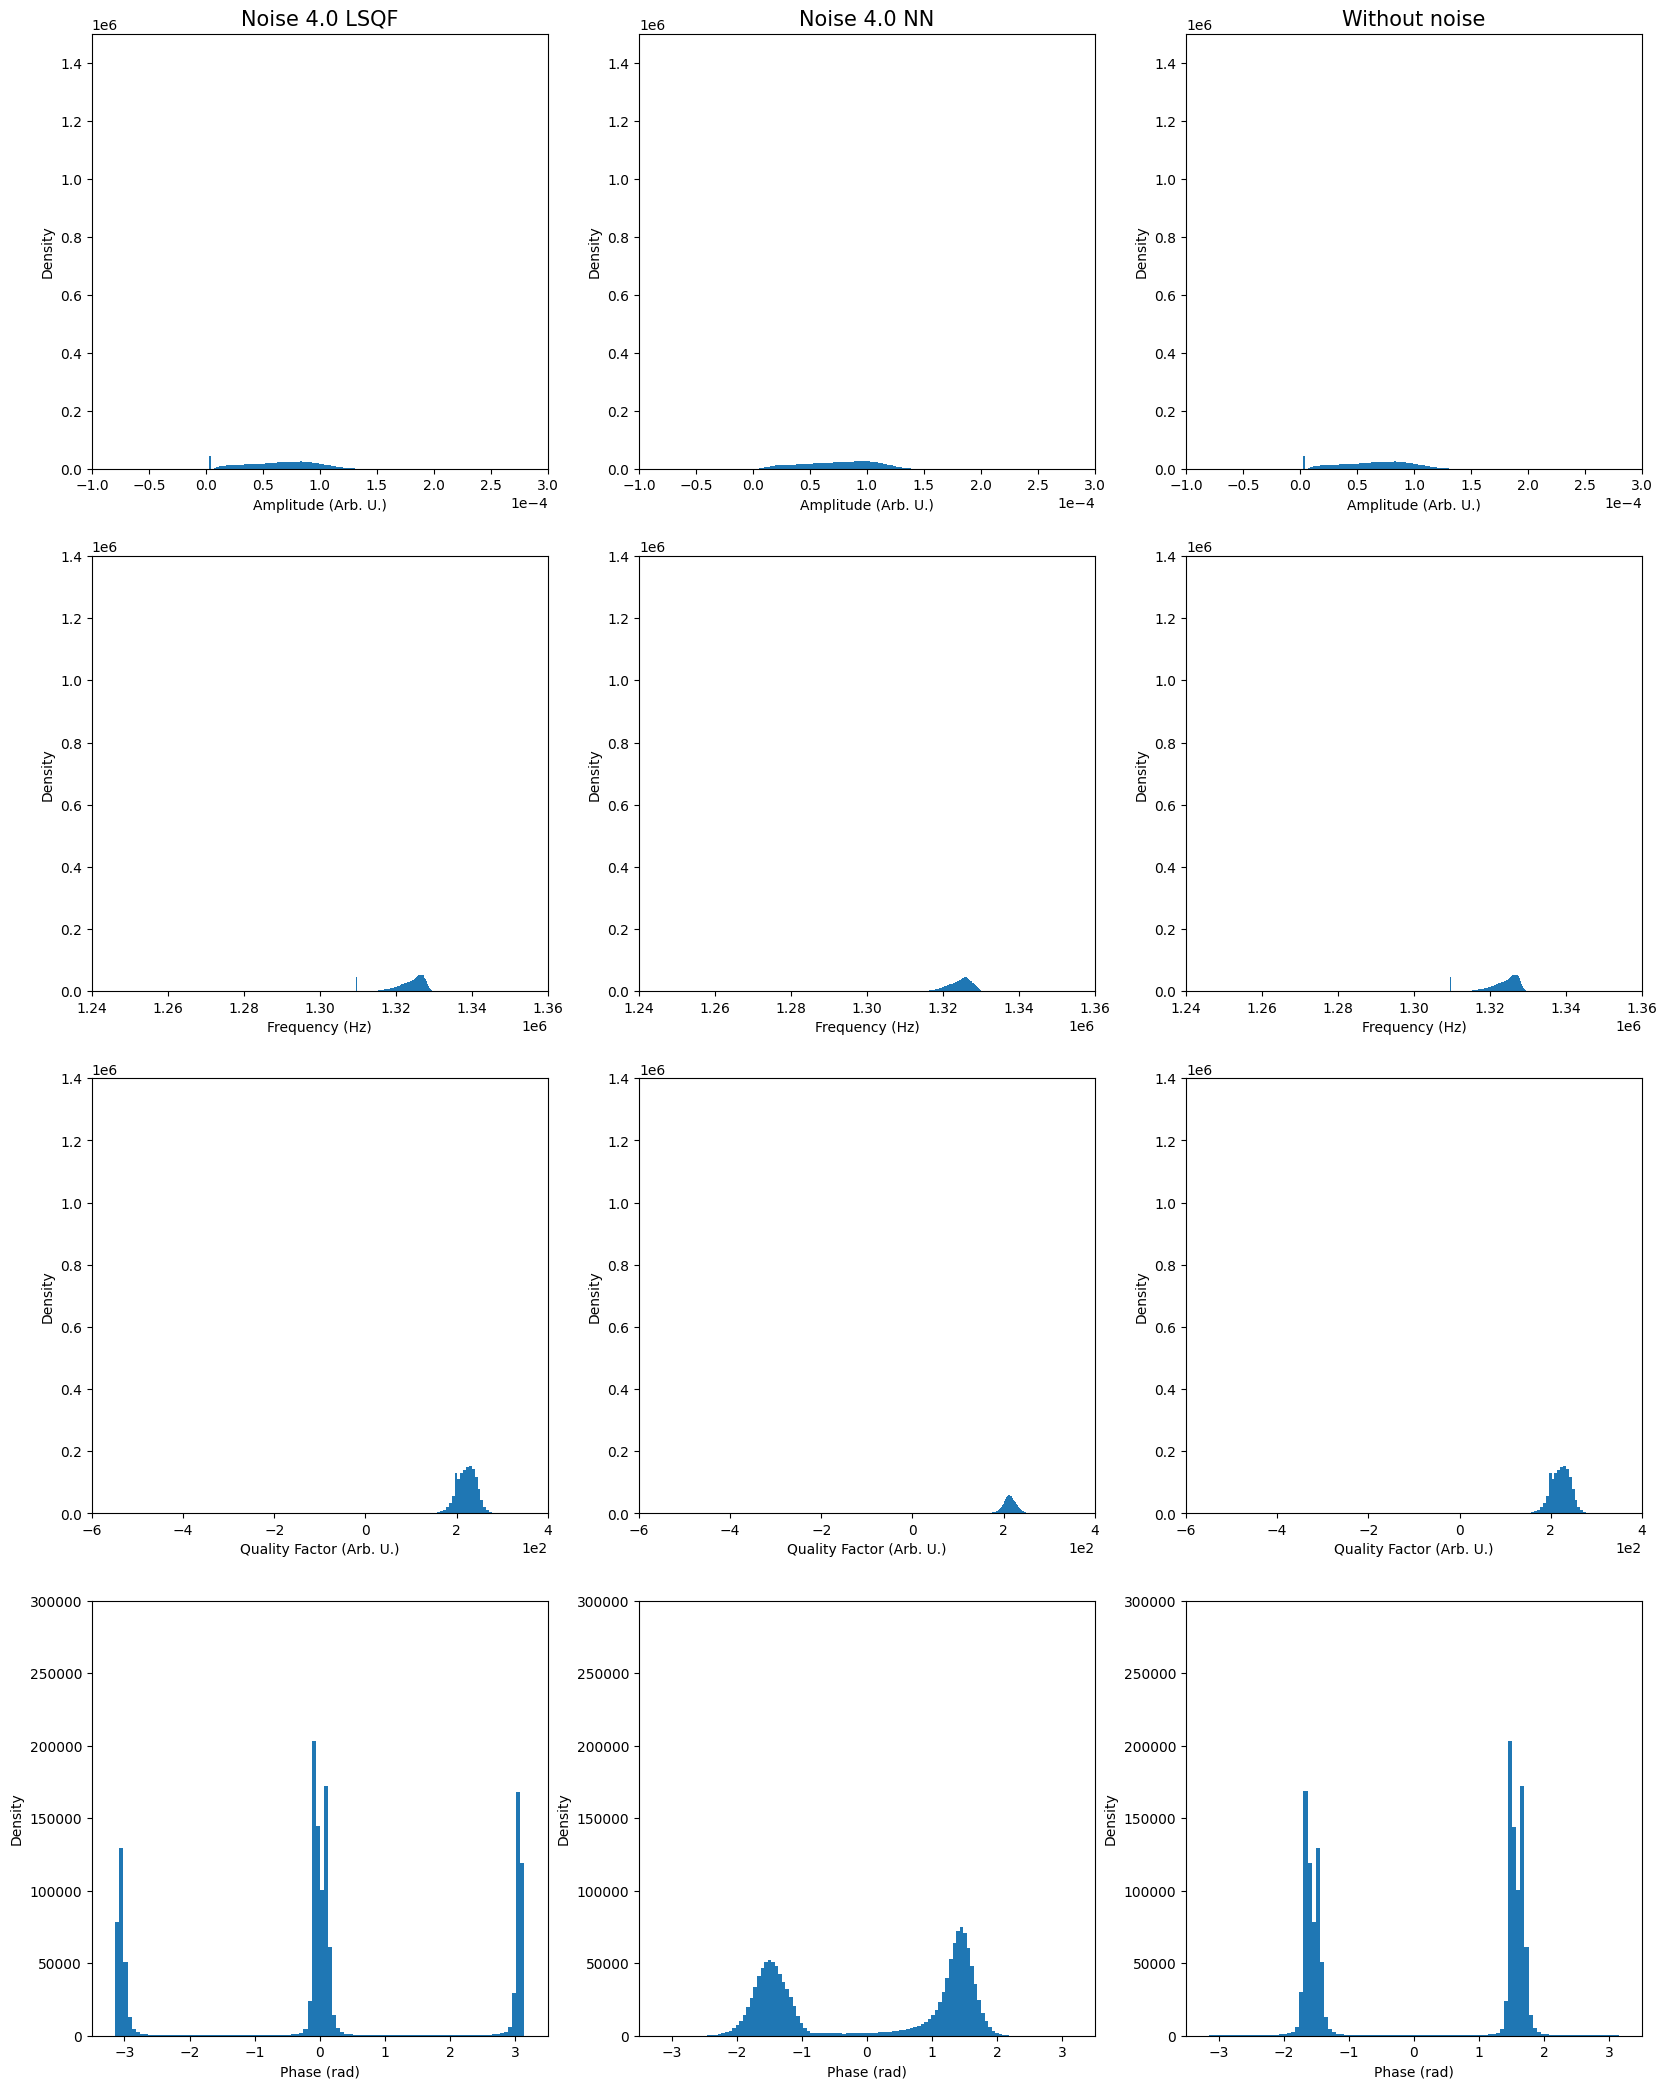

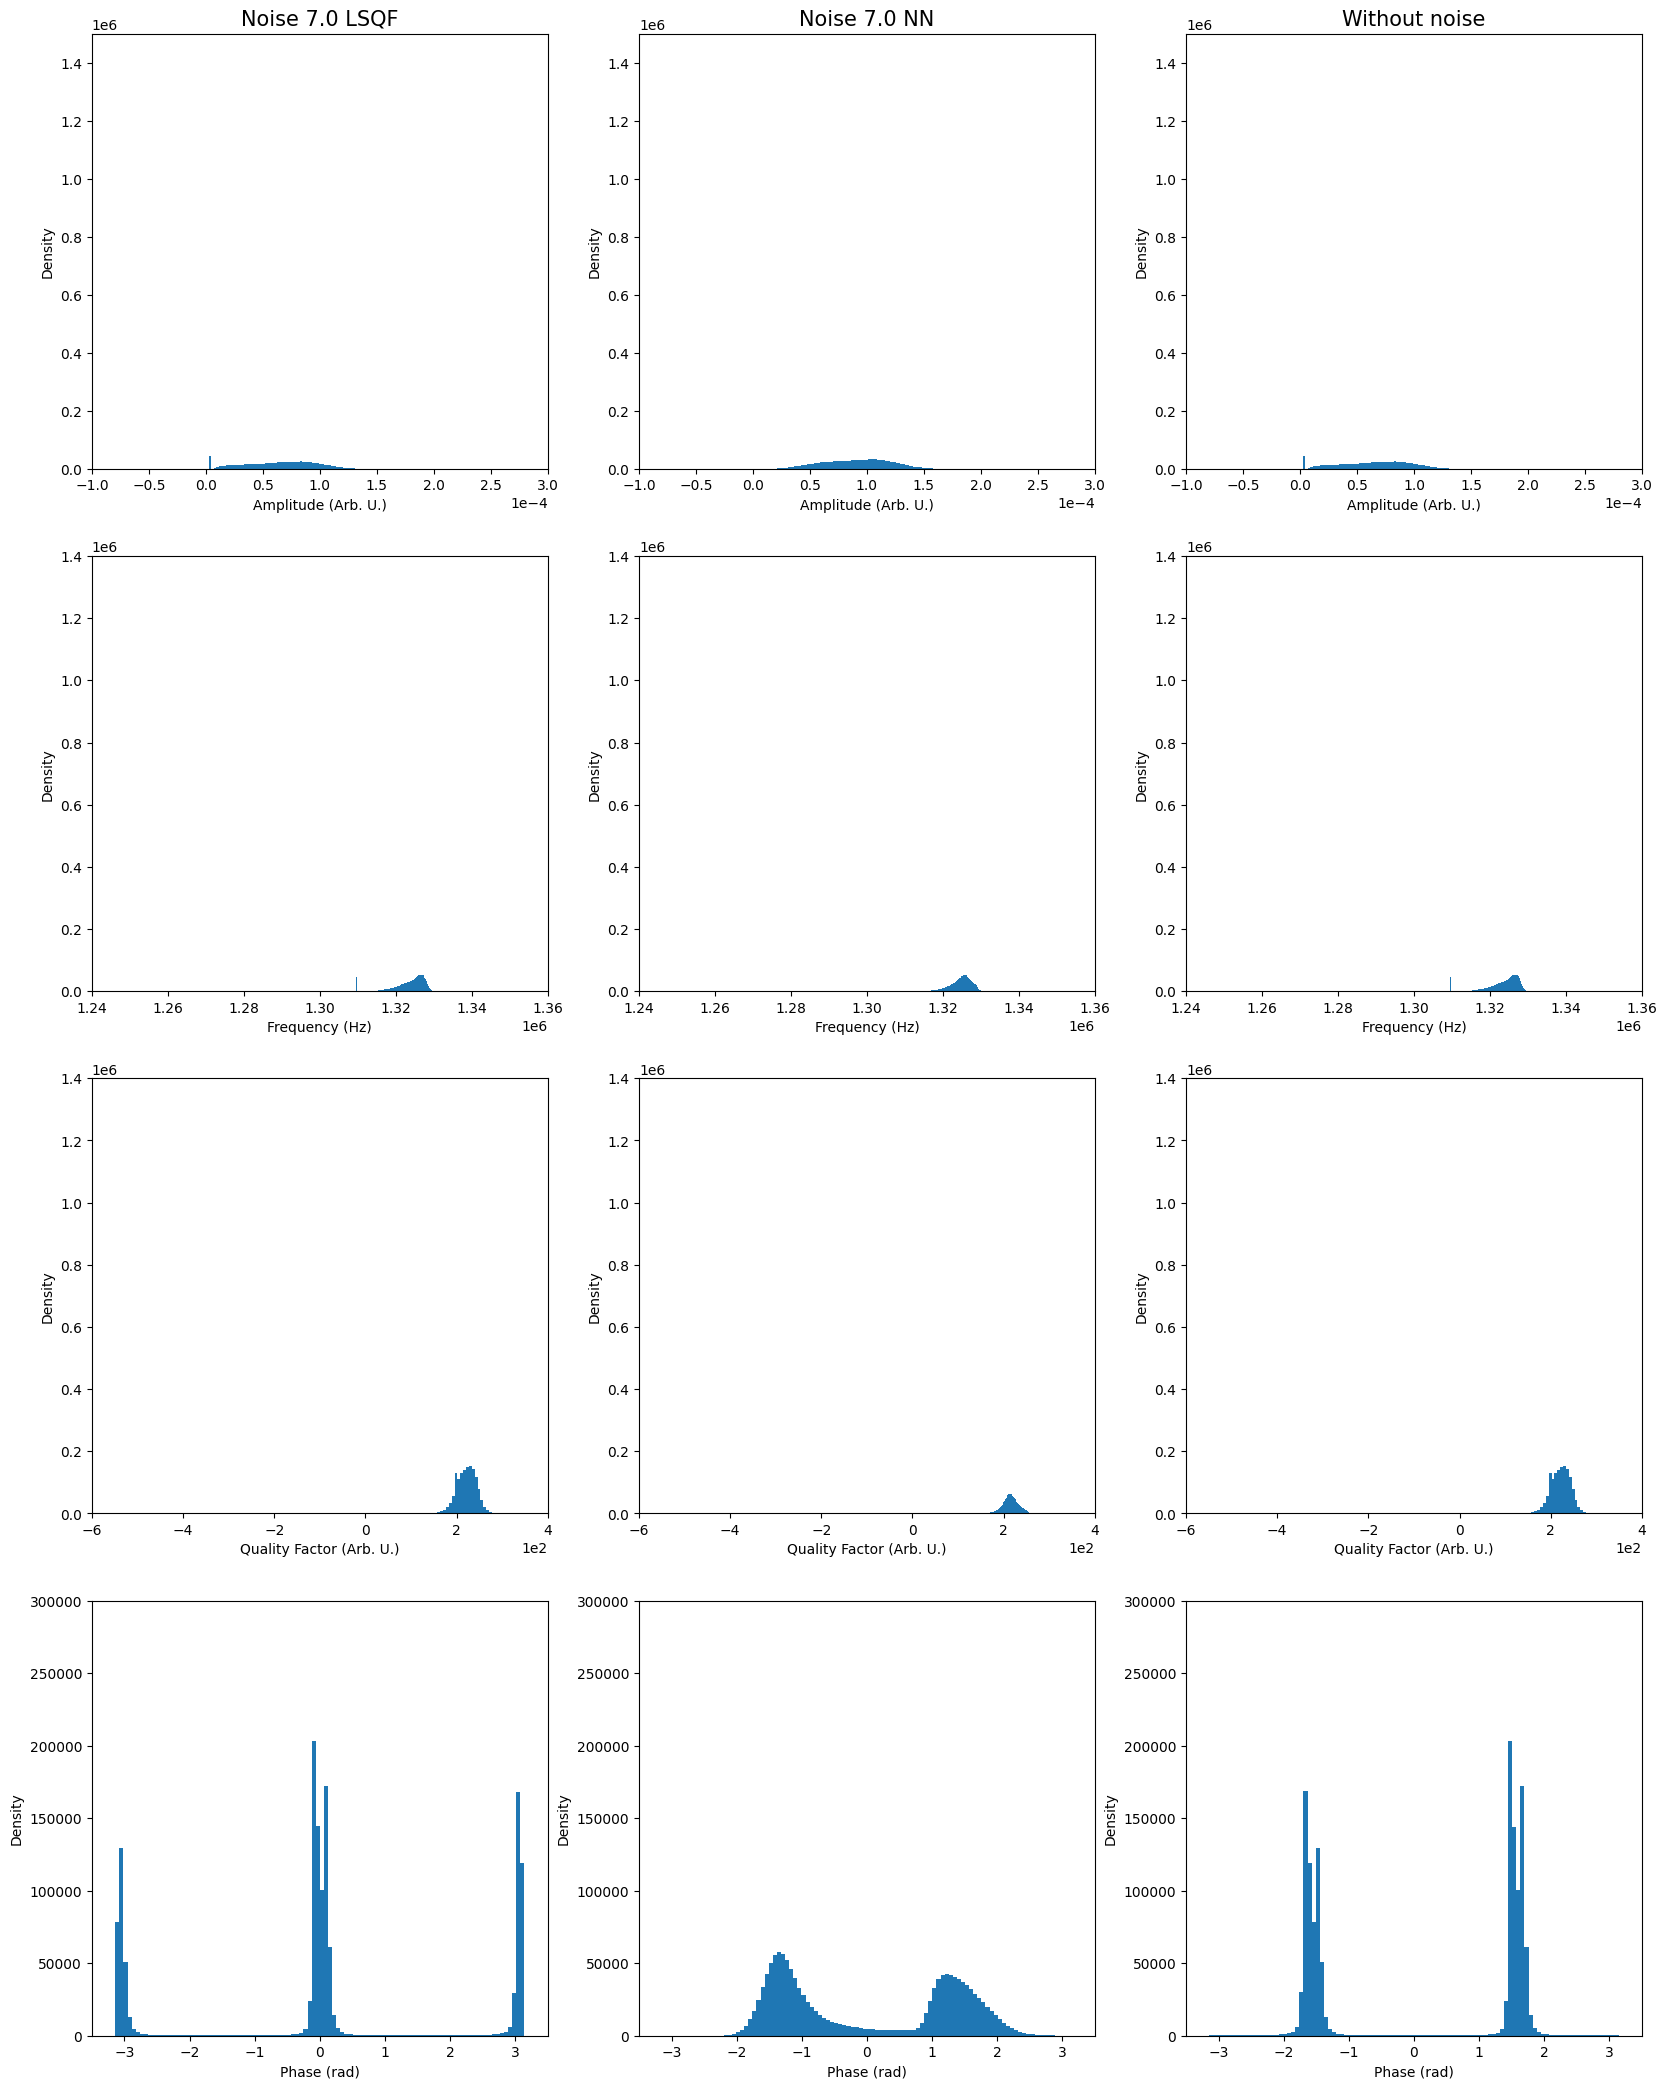

In [21]:
# noisy fits
for nl in noise_levels:
  h5_f_fit_noise = h5py.File(f'./data_file_noise_{nl}.h5', 'r+')
  
  # create a list for parameters
  fit_results_list_noise = SHO_fit_to_array(h5_f_fit_noise["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"])

  gc.collect()
  
  # flatten parameters list into numpy array
  fit_results_list_noise = np.array(fit_results_list_noise).reshape(num_pix,voltage_steps,5)
  fit_results_list_noise = fit_results_list_noise[:, :, :4]

  fit_results_list_transformed_noise, _ = transform_params(fit_results_list_noise.reshape(-1, 4), fit_results_list_noise.reshape(-1, 4))

  del fit_results_list_noise
  gc.collect()
  
  noise_level_float = float(nl)
  
  data_noise_nn = scaled_data + noise_nn_resampled * noise_level_float

  # LOADING PARAMS MODEL
  batch_size = 128
  torch.cuda.empty_cache()
  model_parameters = SHO_Model().cuda()
  model_parameters.load_state_dict(torch.load(f'./Trained Models/SHO Fitter/model_noise_{nl}_bs128.pt'))

  # prediction of parameters
  batch_size = 10000
  train_dataloader = DataLoader(data_noise_nn, batch_size=batch_size)

  num_elements = len(train_dataloader.dataset)
  num_batches = len(train_dataloader)
  all_pred_params = torch.zeros_like(torch.tensor(params))

  for i, train_batch in enumerate(train_dataloader):
      start = i*batch_size
      end = start + batch_size

      if i == num_batches - 1:
          end = num_elements

      pred_batch = model_parameters(train_batch.float().cuda())
      all_pred_params[start:end] = pred_batch.cpu().detach()

      del pred_batch
      del train_batch
      torch.cuda.empty_cache()

  gc.collect()
  
  all_pred_params = all_pred_params.cpu().detach().numpy()

  params_copy = np.copy(params)
  all_pred_params_copy = np.copy(all_pred_params)

  all_params_transformed_noise, all_pred_params_transformed_noise = transform_params(params_copy, all_pred_params_copy)

  all_pred_params_scaled_noise = params_scaler.transform(all_pred_params_transformed_noise)
  all_params_scaled_noise = params_scaler.transform(all_params_transformed_noise)

  if nl == '7.0':
    all_pred_params_transformed_noise[:, 3] = all_pred_params_transformed_noise[:, 3] * -1
    global initial_maps
    global lsqf_maps_7
    global nn_maps_7
    global all_params_transformed
    all_params_transformed = all_params_transformed_noise.copy()
    initial_maps = all_params_transformed_noise[:, :].reshape(num_pix, voltage_steps, -1)[:, ::2][:, voltage_steps//4-1:]
    lsqf_maps_7 = fit_results_list_transformed_noise[:, :].reshape(num_pix, voltage_steps, -1)[:, ::2][:, voltage_steps//4-1:]
    nn_maps_7 = all_pred_params_transformed_noise[:, :].reshape(num_pix, voltage_steps, -1)[:, ::2][:, voltage_steps//4-1:]

    global initial_params
    initial_params = all_params_transformed_noise.copy()
    global lsqf_params_7
    lsqf_params_7 = fit_results_list_transformed_noise.copy()
    global nn_params_7
    nn_params_7 = all_pred_params_transformed_noise.copy()
  elif nl == '4.0':
    global lsqf_maps_4
    global nn_maps_4
    lsqf_maps_4 = fit_results_list_transformed_noise[:, :].reshape(num_pix, voltage_steps, -1)[:, ::2][:, voltage_steps//4-1:]
    nn_maps_4 = all_pred_params_transformed_noise[:, :].reshape(num_pix, voltage_steps, -1)[:, ::2][:, voltage_steps//4-1:]

    global lsqf_params_4
    lsqf_params_4 = fit_results_list_transformed_noise.copy()
    global nn_params_4
    nn_params_4 = all_pred_params_transformed_noise.copy()
  elif nl == '2.0':
    global lsqf_maps_2
    global nn_maps_2
    lsqf_maps_2 = fit_results_list_transformed_noise[:, :].reshape(num_pix, voltage_steps, -1)[:, ::2][:, voltage_steps//4-1:]
    nn_maps_2 = all_pred_params_transformed_noise[:, :].reshape(num_pix, voltage_steps, -1)[:, ::2][:, voltage_steps//4-1:]

    global lsqf_params_2
    lsqf_params_2 = fit_results_list_transformed_noise.copy()
    global nn_params_2
    nn_params_2 = all_pred_params_transformed_noise.copy()
  
  # plot distributions
  fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 26))

  units = ['Amplitude (Arb. U.)', 'Frequency (Hz)', 'Quality Factor (Arb. U.)', 'Phase (rad)']

  for i in range(4):
    axs[i, 0].hist(fit_results_list_transformed_noise[:,i].flatten(), 100)
    axs[i, 1].hist(all_pred_params_transformed_noise[:,i].flatten(), 100)
    axs[i, 2].hist(all_params_transformed_noise[:,i].flatten(), 100)

  i = 0
  for ax in axs.flat:
      ax.set(xlabel=units[i//3], ylabel='Density')
      i+=1
      ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

  axs[0, 0].set_title(f"Noise {nl} LSQF", fontsize=15);
  axs[0, 1].set_title(f"Noise {nl} NN", fontsize=15);
  axs[0, 2].set_title("Without noise", fontsize=15);

  x_min = [-0.1e-3, 1.24e6, -6e2, -3.5]
  x_max = [0.3e-3, 1.36e6, 4e2, 3.5]
  y_max = [1.5e6, 1.4e6, 1.4e6, 0.3e6]

  for j in range(4):
      axs[j, 0].set_xlim(x_min[j], x_max[j])
      axs[j, 1].set_xlim(x_min[j], x_max[j])
      axs[j, 2].set_xlim(x_min[j], x_max[j])
      axs[j, 0].set_ylim(0, y_max[j])
      axs[j, 1].set_ylim(0, y_max[j])
      axs[j, 2].set_ylim(0, y_max[j])
      
  plt.savefig(f'Assets/Figures/comparison_noise_{nl}.png')

In [17]:
amp_min = min(all_params_transformed[:, 0])
amp_max = max(all_params_transformed[:, 0])
res_min = min(all_params_transformed[:, 1])
res_max = max(all_params_transformed[:, 1])
qf_min = min(all_params_transformed[:, 2])
qf_max = max(all_params_transformed[:, 2])
ph_min = min(all_params_transformed[:, 3])
ph_max = max(all_params_transformed[:, 3])

mins = [amp_min, res_min, qf_min, ph_min]
maxs = [amp_max, res_max, qf_max, ph_max]

### Visualizes results in the map form for waveform

In [18]:
sns.reset_orig()
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [19]:
units = ['Amplitude (Arb. U.)', 'Frequency (Hz)', 'Quality Factor\n(Arb. U.)', 'Phase (rad)']
fontsize=14

fig, axs = plt.subplots(14, 12, figsize=(30, 30))
axes = axs.reshape(-1)
for i in range(axes.shape[0]):
    if (i >= 92 and i < 96) or (i >= 104 and i < 108) or (i >= 116 and i < 120) or (i >= 128 and i < 132) or (i >= 140 and i < 144) or (i >= 152 and i < 156) or (i >= 164 and i < 168):
        fig.delaxes(axes[i])
        
for voltage_step in range(0, initial_maps.shape[0], 12):
    if(voltage_step>48):
        break
    
    x, y = 0, 0
    if voltage_step == 0:
        x, y = 0, 0
    elif voltage_step == 12:
        x, y = 0, 4
    elif voltage_step == 24:
        x, y = 0, 8
    elif voltage_step == 36:
        x, y = 7, 0
    elif voltage_step == 48:
        x, y = 7, 4
    
    for param in range(4):
        if (x == 0) and (y == 0 or y == 4 or y == 8):
            axs[x, y+param].text(-1, -8, units[param], rotation='horizontal', fontsize=fontsize)
        if param == 0 and y == 0:
            axs[x, y].set_title("LSQF No Noise", rotation='vertical', x=-0.1, y=0.0, fontsize=fontsize)
            axs[x+1, y].set_title("LSQF Noise 2.0", rotation='vertical', x=-0.1, y=0.0, fontsize=fontsize)
            axs[x+2, y].set_title("LSQF Noise 4.0", rotation='vertical', x=-0.1, y=0.0, fontsize=fontsize)
            axs[x+3, y].set_title("LSQF Noise 7.0", rotation='vertical', x=-0.1, y=0.0, fontsize=fontsize)
            axs[x+4, y].set_title("NN Noise 2.0", rotation='vertical', x=-0.1, y=0.0, fontsize=fontsize)
            axs[x+5, y].set_title("NN Noise 4.0", rotation='vertical', x=-0.1, y=0.0, fontsize=fontsize)
            axs[x+6, y].set_title("NN Noise 7.0", rotation='vertical', x=-0.1, y=0.0, fontsize=fontsize)
            
        im1 = axs[x, y+param].imshow(initial_maps[:, voltage_step, param].reshape(num_pix_1d,num_pix_1d), vmin=mins[param], vmax=maxs[param])
        plt.colorbar(im1, ax=axs[x, y+param], format='%.0e')
        im2 = axs[x+1, y+param].imshow(lsqf_maps_2[:, voltage_step, param].reshape(num_pix_1d,num_pix_1d), vmin=mins[param], vmax=maxs[param])
        plt.colorbar(im2, ax=axs[x+1, y+param], format='%.0e')
        im3 = axs[x+2, y+param].imshow(lsqf_maps_4[:, voltage_step, param].reshape(num_pix_1d,num_pix_1d), vmin=mins[param], vmax=maxs[param])
        plt.colorbar(im3, ax=axs[x+2, y+param], format='%.0e')
        im4 = axs[x+3, y+param].imshow(lsqf_maps_7[:, voltage_step, param].reshape(num_pix_1d,num_pix_1d), vmin=mins[param], vmax=maxs[param])
        plt.colorbar(im4, ax=axs[x+3, y+param], format='%.0e')
        im5 = axs[x+4, y+param].imshow(nn_maps_2[:, voltage_step, param].reshape(num_pix_1d,num_pix_1d), vmin=mins[param], vmax=maxs[param])
        plt.colorbar(im5, ax=axs[x+4, y+param], format='%.0e')
        im6 = axs[x+5, y+param].imshow(nn_maps_4[:, voltage_step, param].reshape(num_pix_1d,num_pix_1d), vmin=mins[param], vmax=maxs[param])
        plt.colorbar(im6, ax=axs[x+5, y+param], format='%.0e')
        im7 = axs[x+6, y+param].imshow(nn_maps_7[:, voltage_step, param].reshape(num_pix_1d,num_pix_1d), vmin=mins[param], vmax=maxs[param])
        plt.colorbar(im7, ax=axs[x+6, y+param], format='%.0e')
        
axs[0, 1].text(72, -8, '●', rotation='horizontal', fontsize=30)
axs[0, 5].text(72, -8, '▼', rotation='horizontal', fontsize=30)
axs[0, 9].text(72, -8, '▲', rotation='horizontal', fontsize=30)
axs[7, 1].text(72, -4, '▶', rotation='horizontal', fontsize=30)
axs[7, 5].text(72, -4, '◀', rotation='horizontal', fontsize=30)
        
for i in range(axes.shape[0]):
    axes[i].axis('off')
  
plt.tight_layout()
plt.savefig('Assets/Figures/loss_comparison_maps.svg')
plt.savefig('Assets/Figures/loss_comparison_maps.png')

### Visualize distribution of parameters using violin plots

In [20]:
all_params_transformed, all_pred_params_transformed = transform_params(params.copy(), all_pred_params.copy())

initial_params = (initial_params - params_scaler.mean_) / (params_scaler.var_ ** 0.5)
all_pred_params_transformed = (all_pred_params_transformed - params_scaler.mean_) / (params_scaler.var_ ** 0.5)
lsqf_params_2 = (lsqf_params_2 - params_scaler.mean_) / (params_scaler.var_ ** 0.5)
nn_params_2 = (nn_params_2 - params_scaler.mean_) / (params_scaler.var_ ** 0.5)
lsqf_params_4 = (lsqf_params_4 - params_scaler.mean_) / (params_scaler.var_ ** 0.5)
nn_params_4 = (nn_params_4 - params_scaler.mean_) / (params_scaler.var_ ** 0.5)
lsqf_params_7 = (lsqf_params_7 - params_scaler.mean_) / (params_scaler.var_ ** 0.5)
nn_params_7 = (nn_params_7 - params_scaler.mean_) / (params_scaler.var_ ** 0.5)

In [21]:
df_to_plot_comp = pd.DataFrame(np.vstack((all_pred_params_transformed, nn_params_2, nn_params_7, initial_params, lsqf_params_2, lsqf_params_7)))
df_to_plot_comp = df_to_plot_comp.melt(var_name='Params', value_name='Normalized Params')
df_to_plot_comp['Fit Type'] = 'NN'
df_to_plot_comp['Noise'] = '0.0'

for i in range(1,25,6):
  df_to_plot_comp.loc[i*initial_params.shape[0]:(i+1)*initial_params.shape[0], 'Fit Type'] = 'NN'
  df_to_plot_comp.loc[i*initial_params.shape[0]:(i+1)*initial_params.shape[0], 'Noise'] = '2.0'

for i in range(2,25,6):
  df_to_plot_comp.loc[i*initial_params.shape[0]:(i+1)*initial_params.shape[0], 'Fit Type'] = 'NN'
  df_to_plot_comp.loc[i*initial_params.shape[0]:(i+1)*initial_params.shape[0], 'Noise'] = '7.0'

for i in range(3,25,6):
  df_to_plot_comp.loc[i*initial_params.shape[0]:(i+1)*initial_params.shape[0], 'Fit Type'] = 'LSQF'
  df_to_plot_comp.loc[i*initial_params.shape[0]:(i+1)*initial_params.shape[0], 'Noise'] = '0.0'

for i in range(4,25,6):
  df_to_plot_comp.loc[i*initial_params.shape[0]:(i+1)*initial_params.shape[0], 'Fit Type'] = 'LSQF'
  df_to_plot_comp.loc[i*initial_params.shape[0]:(i+1)*initial_params.shape[0], 'Noise'] = '2.0'

for i in range(5,25,6):
  df_to_plot_comp.loc[i*initial_params.shape[0]:(i+1)*initial_params.shape[0], 'Fit Type'] = 'LSQF'
  df_to_plot_comp.loc[i*initial_params.shape[0]:(i+1)*initial_params.shape[0], 'Noise'] = '7.0'

In [22]:
labels = ['Amplitude', 'Resonance', 'Q-Factor', 'Phase']

sns.set_style("ticks")
sns.catplot(x='Params', y='Normalized Params', hue='Fit Type', col='Noise', data=df_to_plot_comp, kind='violin', scale='count', split=True, inner='quartile')

plt.tight_layout()
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.savefig('Assets/Figures/violin_SHO_params_comparison_noise.png', bbox_inches='tight', pad_inches=1)
plt.savefig('Assets/Figures/violin_SHO_params_comparison_noise.svg', bbox_inches='tight', pad_inches=1)